In [2]:
import sys
import os
import numpy as np
import time

# 현재 파일(main.ipynb)이 있는 디렉토리의 부모 디렉토리를 sys.path에 추가
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [141]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import copy

In [101]:
from state.ver2 import *

In [53]:
def check_consecutive(board):
    indices = np.arange(N_ACTIONS)[board.astype(bool).reshape(-1)] 

    for index in indices:
        _, col = divmod(index, STATE_SHAPE[1]) 

        if col < STATE_SHAPE[1] - WINNING_CONDITION:
            row_lst = list(range(index, index+WINNING_CONDITION))
            is_row = all(element in indices for element in row_lst)

            if is_row:
                return True, row_lst
            
        
        diag_lst = list(range(index, index+(WINNING_CONDITION-1)*(STATE_SHAPE[1]+1)+1, STATE_SHAPE[1]+1))
        anti_diag_lst = list(range(index, index+(WINNING_CONDITION-1)*(STATE_SHAPE[1]-1)+1, STATE_SHAPE[1]-1))
        col_lst = list(range(index, index+(WINNING_CONDITION-1)*STATE_SHAPE[1]+1, STATE_SHAPE[1]))

        is_diag = all(element in indices for element in diag_lst)
        is_anti_diag = all(element in indices for element in anti_diag_lst)
        is_col = all(element in indices for element in col_lst)

        if is_diag:
            return True, diag_lst
    
        elif is_anti_diag:
            return True, anti_diag_lst
        
        elif is_col:
            return True, col_lst
                
    return False, []


In [84]:
def is_first_player(state):
        n_my_actions = np.sum(state[0])
        n_enemy_actions = np.sum(state[1])
        return (n_my_actions + n_enemy_actions) % 2 == 0  

def divide(x):
    return divmod(x, STATE_SHAPE[1])

In [ ]:
def draw_omok_board(state, new_action=None):

    board = state[0] + state[1] * -1 if is_first_player(state) else state[0] * -1 + state[1]
    nrow, ncol = board.shape

    # create a figure for visualization
    _, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(-2, ncol + 1)
    ax.set_ylim(nrow + 1, -2)
    ax.set_facecolor('#d2a155')

    # draw the grid of Omok Board
    for i in range(-1, nrow + 1):
        ax.plot([i, i], [-1, ncol], color='black', zorder=1)
        ax.plot([-1, nrow], [i, i], color='black', zorder=1)

    # draw the pieces 
    for x in range(nrow):
        for y in range(ncol):
            if board[x, y] == 1:
                black_action = patches.Circle((y, x), 0.4, edgecolor='black', facecolor='black', zorder=3)
                ax.add_patch(black_action)

            elif board[x, y] == -1:
                white_action = patches.Circle((y, x), 0.4, edgecolor='black', facecolor='white', zorder=3)
                ax.add_patch(white_action)

    # if next action exists, draw it in the board 
    if new_action is not None:
        x, y = divmod(new_action, ncol)
        facecolor = 'black' if is_first_player(state) else 'white'

        new_action_patch = patches.Circle((y, x), 0.4, edgecolor='red', facecolor=facecolor, zorder=3)
        ax.add_patch(new_action_patch)

        state[0][x,y] = 1 

    # check consecutive and draw when it exists
    val, indices_lst = check_consecutive(state[0])

    if val is not True:
        val, indices_lst = check_consecutive(state[1])

    if val:
        result = list(map(divide, indices_lst))

        rows, cols = zip(*result)  
        rows, cols = list(rows), list(cols)   

        ax.plot(cols, rows, color='#70d96b', marker='.', lw=2.5, zorder=4) 


    # Add title and labels 
    if new_action is None:
        plt.title(f"State : without next action")
    else:
        plt.title(f"State : with next action")

    # draw the red line above all elements
    # ax.plot([0,1,2,3,4], [0]*5, color='#70d96b', marker='.', lw=2, zorder=4) 
    ax.set_xticks(range(0, ncol))
    ax.set_yticks(range(0, nrow))

    plt.show()


# Test case for visualization
state = State([1, 2, 3, 4], list(range(23, 55, 8)) + [10])
draw_omok_board(state(), 5)
# state = State(list(range(23, 55, 8)), [1, 2, 3, 4])
# draw_omok_board(state(), 55)


In [129]:
def divide(x):
    row, col = divmod(x, STATE_SHAPE[1])
    row , col = row + 0.5, col + 0.5
    return (row, col)

In [296]:
def check_consecutive(board):
    def _make_diag_mask():
        mask = np.zeros(shape=STATE_SHAPE, dtype=bool)
        mask[:, -(WINNING_CONDITION-1):] = 1
        return mask
    
    indices = np.arange(N_ACTIONS)[board.astype(bool).reshape(-1)] 
    
    # mask & unavailble idx list 
    diag_mask = _make_diag_mask()
    anti_diag_mask = diag_mask[:,::-1]

    diag_idx_list = list(np.arange(N_ACTIONS).reshape(STATE_SHAPE)[diag_mask])
    anti_diag_idx_list = list(np.arange(N_ACTIONS).reshape(STATE_SHAPE)[anti_diag_mask])           

    for index in indices:
        # find diag & row-consecutive list  
        if index not in diag_idx_list:
                diag_lst = list(range(index, index+(WINNING_CONDITION-1)*(STATE_SHAPE[1]+1)+1, STATE_SHAPE[1]+1))
                row_lst = list(range(index, index+WINNING_CONDITION))

                is_row = all(element in indices for element in row_lst)
                is_diag = all(element in indices for element in diag_lst)

                if is_diag:
                    return True, diag_lst
                elif is_row:
                    return True, row_lst
                
        # find anti-diag-consecutive list  
        if index not in anti_diag_idx_list:
                anti_diag_lst = list(range(index, index+(WINNING_CONDITION-1)*(STATE_SHAPE[1]-1)+1, STATE_SHAPE[1]-1))
                is_anti_diag = all(element in indices for element in anti_diag_lst)

                if is_anti_diag:
                    return True, anti_diag_lst
                           
        # find col-consecutive list  
        col_lst = list(range(index, index+(WINNING_CONDITION-1)*STATE_SHAPE[1]+1, STATE_SHAPE[1]))
        is_col = all(element in indices for element in col_lst)

        if is_col:
            return True, col_lst
                
    return False, []

In [ ]:
def draw_omok_board(state, next_action=None, ax=None):
    state = copy.deepcopy(state)
    board = state[0] + state[1] * -1 if is_first_player(state) else state[0] * -1 + state[1]
    nrow, ncol = board.shape

    # create a figure for visualization
    if ax is None:
        _, ax = plt.subplots(figsize=(6,6))

    ax.set_xlim(0, ncol)
    ax.set_ylim(nrow,0)
    ax.set_facecolor('#d2a155')

    # draw the grid of Omok Board
    for i in range(-1, nrow + 1):
        ax.plot([i-0.5, i-0.5], [0.5, ncol-0.5], color='black', zorder=1)
        ax.plot([0.5, nrow-0.5], [i-0.5, i-0.5], color='black', zorder=1)

    # draw the pieces 
    for x in range(nrow):
        for y in range(ncol):
            if board[x, y] == 1:
                black_action = patches.Circle((y+0.5, x+0.5), 0.4, edgecolor='black', facecolor='black', zorder=3)
                ax.add_patch(black_action)

            elif board[x, y] == -1:
                white_action = patches.Circle((y+0.5, x+0.5), 0.4, edgecolor='black', facecolor='white', zorder=3)
                ax.add_patch(white_action)

    # if next action exists, draw it in the board 
    if next_action is not None:
        x, y = divmod(next_action, ncol)
        facecolor = 'black' if is_first_player(state) else 'white'

        next_action_patch = patches.Circle((y+0.5, x+0.5), 0.4, edgecolor='red', facecolor=facecolor, zorder=3)
        ax.add_patch(next_action_patch)

        state[0][x,y] = 1 

    # check consecutive and draw when it exists
    val, indices_lst = check_consecutive(state[0])

    if val is not True:
        val, indices_lst = check_consecutive(state[1])
        print(val)
        print(indices_lst)

    if val:
        result = list(map(divide, indices_lst))

        rows, cols = zip(*result)  
        rows, cols = list(rows) , list(cols) 

        ax.plot(cols, rows, color='#70d96b', marker='.', lw=2.5, zorder=4) 


    # Add title and labels 
    if next_action is None:
        ax.set_title(f"State : without next action")
    else:
        ax.set_title(f"State : with next action")

    # draw the red line above all elements
    ax.set_xticks(range(0, ncol))
    ax.set_yticks(range(0, nrow))
    ax.set_aspect('equal')


# Test case for visualization
# state = State([1, 2, 3, 4], list(range(23, 55, 8)) + [10])
state = State(list(range(23, 55, 8)) + [10], list(range(4,9)))
draw_omok_board(state())

# state = State(list(range(23, 55, 8)), [1, 2, 3, 4])
# draw_omok_board(state(), 55)


In [ ]:
def visualize_MCTS_visits(visits, state, next_action=None, ax=None, agent_type='recent'):

    color_dict = {'best' : 'PuRd',
                  'recent' : 'GnBu'}
    
    visits = np.array(visits).reshape(STATE_SHAPE)

    board = state[0] + state[1] * -1 if is_first_player(state) else state[0] * -1 + state[1]
    nrow, ncol = board.shape

    if ax is None:
        _, ax = plt.subplots(figsize=(6,6))


    ax.set_xlim(0, ncol + 1)
    ax.set_ylim(nrow + 1, 0)
    ax.set_facecolor('#F5F5F5')

    # draw the grid of Omok Board
    for i in range(0, nrow + 1):
        ax.plot([i-0.5, i-0.5], [0.5, ncol-0.5], color='gray', alpha=0.5, zorder=1)
        ax.plot([0.5, nrow-0.5], [i-0.5, i-0.5], color='gray', alpha=0.5, zorder=1)

    # draw the pieces 
    for x in range(nrow):
        for y in range(ncol):
            if board[x, y] == 1:
                black_action = patches.Circle((y+0.5, x+0.5), 0.35, edgecolor='gray', facecolor='gray', zorder=2)
                ax.add_patch(black_action)

            elif board[x, y] == -1:
                white_action = patches.Circle((y+0.5, x+0.5), 0.35, edgecolor='gray', facecolor='white', zorder=2)
                ax.add_patch(white_action)

    if next_action is not None:
        x, y = divmod(next_action, ncol)
        facecolor = 'gray' if is_first_player(state) else 'white'

        new_action_patch = patches.Circle((y+0.5, x+0.5), 0.4, edgecolor='red', facecolor=facecolor, zorder=3)
        ax.add_patch(new_action_patch)

    
    annot_data = np.where(visits == 0, "", visits)

    # Overlay the heatmap
    sns.heatmap(visits, ax=ax, square=True, annot=annot_data, cbar=True, fmt='', cmap=color_dict[agent_type], alpha=0.5, annot_kws={"size": 10, "weight": "bold"}, zorder=3)
    
    ax.set_title("MCTS visits")

visit = [0] * N_ACTIONS
visit[5] = 10
visit[0] = 2

visualize_MCTS_visits(visit, state(), 5)
    

In [ ]:
def visualize_current_policy(policy, state, next_action=None, ax=None, agent_type='recent'):

    color_dict = {'best' : 'OrRd',
                  'recent' : 'BuPu'}
    
    policy = np.array(policy).reshape(STATE_SHAPE).round(2)

    board = state[0] + state[1] * -1 if is_first_player(state) else state[0] * -1 + state[1]
    nrow, ncol = board.shape

    if ax is None:
        _, ax = plt.subplots(figsize=(6,6))

    ax.set_xlim(0, ncol + 1)
    ax.set_ylim(nrow + 1, 0)
    ax.set_facecolor('#F5F5F5')

    # draw the grid of Omok Board
    for i in range(0, nrow + 1):
        ax.plot([i-0.5, i-0.5], [0.5, ncol-0.5], color='gray', alpha=0.5, zorder=1)
        ax.plot([0.5, nrow-0.5], [i-0.5, i-0.5], color='gray', alpha=0.5, zorder=1)

    # draw the pieces 
    for x in range(nrow):
        for y in range(ncol):
            if board[x, y] == 1:
                black_action = patches.Circle((y+0.5, x+0.5), 0.35, edgecolor='gray', facecolor='gray', zorder=2)
                ax.add_patch(black_action)

            elif board[x, y] == -1:
                white_action = patches.Circle((y+0.5, x+0.5), 0.35, edgecolor='gray', facecolor='white', zorder=2)
                ax.add_patch(white_action)

    if next_action is not None:
        x, y = divmod(next_action, ncol)
        facecolor = 'gray' if is_first_player(state) else 'white'

        new_action_patch = patches.Circle((y+0.5, x+0.5), 0.4, edgecolor='red', facecolor=facecolor, zorder=3)
        ax.add_patch(new_action_patch)

    
    annot_data = np.where(policy == 0, "", policy)

    # Overlay the heatmap
    sns.heatmap(policy, ax=ax, square=True, annot=annot_data, cbar=True, fmt='', cmap=color_dict[agent_type], alpha=0.5, annot_kws={"size": 10, "weight": "bold"}, zorder=3)
    # BuPu
    ax.set_title("current Policy")

policy = [0] * N_ACTIONS
policy[5] = .12
policy[0] = .342

visualize_current_policy(policy, state(), 5)
    

In [189]:
policy = [0] * N_ACTIONS
policy[5] = .12
policy[0] = .342

visit = [0] * N_ACTIONS
visit[5] = 10
visit[0] = 2

state = State(list(range(23, 55, 8)), [1, 2, 3, 4])

In [ ]:
next_action = 55
agent_type = 'best'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
draw_omok_board(state(), next_action=next_action, ax=axes[0])
visualize_MCTS_visits(visit, state(), next_action=next_action, agent_type=agent_type, ax=axes[1])
visualize_current_policy(policy, state(), next_action=next_action, agent_type=agent_type, ax=axes[2])
plt.tight_layout()
plt.suptitle(agent_type, fontsize=26, fontweight='bold', y=1.02)
plt.show()

In [ ]:
def visualize_pack(agent_type,state, next_action, download=False, path=None):

    _, axes = plt.subplots(1, 3, figsize=(18, 6))

    draw_omok_board(state, next_action=next_action, ax=axes[0])
    visualize_MCTS_visits(visit, state, next_action=next_action, agent_type=agent_type, ax=axes[1])
    visualize_current_policy(policy, state, next_action=next_action, agent_type=agent_type, ax=axes[2])

    plt.tight_layout()
    plt.suptitle(agent_type, fontsize=26, fontweight='bold', y=1.02)

    if download:
        if path is None:
            path = os.path.abspath(os.path.join(os.getcwd(), ".."))

        plt.savefig(f"{path}/loss.png", dpi=300, bbox_inches='tight')

    plt.show()
    

In [ ]:
next_action = 55
agent_type = 'recent'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
draw_omok_board(state(), next_action=next_action, ax=axes[0])
visualize_MCTS_visits(visit, state(), next_action=next_action, agent_type=agent_type, ax=axes[1])
visualize_current_policy(policy, state(), next_action=next_action, agent_type=agent_type, ax=axes[2])
plt.tight_layout()
plt.suptitle(agent_type, fontsize=26, fontweight='bold', y=1.02)
plt.show()

# bar

In [ ]:
result = {'win': 10, 'draw': 5, 'lose': 6}

def visualize_game_result(result:dict):
    # 데이터 준비
    categories = list(result.keys())
    values = list(result.values())

    # 파이차트 그리기
    plt.figure(figsize=(6, 6))

    wedges, texts, autotexts = plt.pie(
        values, 
        labels=categories,  # 카테고리 레이블
        autopct=lambda p: f'{p:.1f}%\n({int(p * sum(values) / 100)})',  # 비율과 개수 표시
        startangle=90,      # 시작 각도
        colors=['#76c893', '#f4d35e', '#e63946'],  # 색상 설정
        textprops=dict(color="black", fontsize=12, weight='bold')  # 텍스트 스타일
    )

    # 차트 제목
    plt.title("Game Results Distribution", fontsize=16, fontweight='bold')

    # 범례 추가
    plt.legend(wedges, categories, title="Results", loc="upper right", bbox_to_anchor=(1.2, 1))

    # 그래프 표시
    plt.show()

visualize_game_result(result)

# 기보 시각화 

In [ ]:
def visualize_game_record(game_action_list, ax=None):
    nrow, ncol = STATE_SHAPE

    # Create a figure for visualization
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    ax.set_xlim(0, ncol)
    ax.set_ylim(nrow, 0)
    ax.set_facecolor('#d2a155')

    # Draw the grid of Omok Board
    for i in range(-1, nrow + 1):
        ax.plot([i - 0.5, i - 0.5], [0.5, ncol - 0.5], color='black', zorder=1)
        ax.plot([0.5, nrow - 0.5], [i - 0.5, i - 0.5], color='black', zorder=1)

    # Draw the pieces
    for idx, action in enumerate(game_action_list):
        x, y = divmod(action, ncol)

        if idx % 2 == 0:  # Black stone
            black_action = patches.Circle((y + 0.5, x + 0.5), 0.4, edgecolor='black', facecolor='black', zorder=2)
            ax.add_patch(black_action)
            ax.text(y + 0.5, x + 0.5, str(idx + 1), color='white', ha='center', va='center', fontsize=12, zorder=3)

        else:  # White stone
            white_action = patches.Circle((y + 0.5, x + 0.5), 0.4, edgecolor='black', facecolor='white', zorder=2)
            ax.add_patch(white_action)
            ax.text(y + 0.5, x + 0.5, str(idx + 1), color='black', ha='center', va='center', fontsize=12, zorder=3)

        ax.set_title("Game Record")


game_action_list = random.sample(range(81), 20)  # Example game moves

visualize_game_record(game_action_list)
plt.show()

In [ ]:
arr = np.zeros(shape=(3,3))

type(arr)

# Download

In [2]:
import os

In [3]:
os.path.abspath(os.path.join(os.getcwd(), ".."))

'/Users/ijimin/Documents/GitHub/AiGO/Omok/Jimin'

In [4]:
os.path.join(os.getcwd(), "..")

'/Users/ijimin/Documents/GitHub/AiGO/Omok/Jimin/visual_lab/..'

In [ ]:
    # def save_model(self):
        
    #     path = f'{self.path}/{self.name}'

    #     # 디렉토리 생성
    #     if not os.path.exists(path):
    #         os.makedirs(path)  

    #     torch.save(self.best_model.state_dict(), f'{path}/best_model_weight.pth')

In [7]:
import torch

In [ ]:
def get_cwd_path(fname, path_name=None):
    f_cwd = os.path.abspath(os.path.join(os.getcwd(), ".."))
    f_path = f"{f_cwd}/{path_name}/{fname}" if path_name is not None else f"{f_cwd}/{path_name}"
    return f_cwd, f_path

F_CWD, F_PATH = get_cwd_path('Omok_1', 'model')

def make_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"'{path}' directory is created.")
    else:
        print(f"'{path}' already exists.")

def save_model(model):
    torch.save(model.state_dict(), f'{F_PATH}/best_model_weight.pth')
    print("Model saving complete.")

def load_model(model_body, f_name):
    params = torch.load(f"{F_PATH}/{f_name}", weights_only=False)
    model = model_body.load_state_dict(params)
    print("Model is loaded.")
    return model 

def make_valid_file_path(idx):
    # make path 
    valid_point_path = f"{F_PATH}/valid_{idx}"
    make_directory(valid_point_path)
    

In [11]:
l = {'lose' : 10, 'draw' : 20, 'win' : 40}

In [16]:
round(l['win'] / sum(l.values()), 2)

0.57

In [18]:
l = [(0.43, 0.54), (.95, .43), (.54, .65)]

win, win_draw = zip(*l)
win, win_draw = list(win), list(win_draw)
win, win_draw

([0.43, 0.95, 0.54], [0.54, 0.43, 0.65])

In [20]:
import matplotlib.pyplot as plt

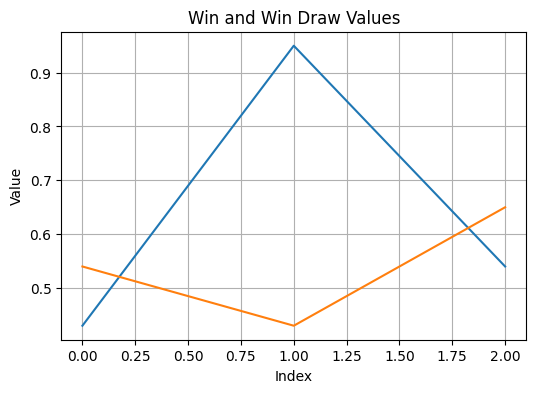

In [26]:
plt.figure(figsize=(6, 4))
# plt.plot(win, marker='o', linestyle='-', label="win")
# plt.plot(win_draw, marker='s', linestyle='-', label="win_draw", color='r')

plt.plot(l)
# 그래프 설정
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Win and Win Draw Values")
plt.grid(True)
plt.show()

In [ ]:
def visualize_win_rate(win_rates, ax=None, path=None, download=False):
    # Create a figure for visualization
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    # seperate data
    win, win_draw = zip(*win_rates)
    win, win_draw = list(win), list(win_draw)
    win, win_draw

    # graphing
    ax.plot(win, marker='o', linestyle='-', label="win")
    ax.plot(win_draw, marker='s', linestyle='-', label="win_draw", color='r')
    ax.set_xticks(range(0, len(win_rates)))

    ax.xlabel("rate")
    ax.ylabel("steps")
    ax.title("Win and Win Draw Rate per steps")
    ax.legend()
    ax.grid(True)
    ax.show()

    if download:
        if path is None:
            path = os.path.abspath(os.path.join(os.getcwd(), ".."))
        plt.savefig(f"{path}/win_rate.png", dpi=300, bbox_inches='tight')


In [ ]:
def visualize_loss(losses, ax=None, path=None, download=False):
    # Create a figure for visualization
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    # seperate data
    p, v, total = zip(*losses)

    # graphing
    ax.plot(p, linestyle='-', label="policy")
    ax.plot(v, linestyle='-', label="value")
    ax.plot(total, linestyle='-', label="total")

    ax.set_xticks(range(0, len(losses)))

    ax.xlabel("loss")
    ax.ylabel("steps")
    ax.title("LOSS per steps")
    ax.legend()
    ax.grid(True)
    ax.show()

    if download:
        if path is None:
            path = os.path.abspath(os.path.join(os.getcwd(), ".."))
        plt.savefig(f"{path}/loss.png", dpi=300, bbox_inches='tight')
